In [9]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import numpy as np

import transformers

from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import FuncFormatter


In [10]:
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Times New Roman']
mpl.rcParams['mathtext.fontset'] = 'cm'
# bigger size
mpl.rcParams['font.size'] = 14

In [11]:
from src.utils import hex_to_str, str_to_hex
from src.train_subword import build_gpt_tokenizer


## Load FLORES dataset

In [12]:
# load flores dataset for languages: en, es, pt, fr, it, ro, pl, mt, ja, zh, ko, te, ta
languages = ['en', 'es', 'pt', 'fr', 'it', 'ro', 'pl', 'mt','he', 'ar', 'ja', 'ko', 'te', 'ta', 'si']

palette = sns.color_palette("viridis", len(languages))
languages_colors = {lang: col for lang, col in zip(languages, palette)}
nice_colors = [ ]
languages_flores = {'en': 'eng_Latn',
                    'es': 'spa_Latn',
                    'pt': 'por_Latn',
                    'fr': 'fra_Latn',
                    'it': 'ita_Latn',
                    'ro': 'ron_Latn',
                    'pl': 'pol_Latn',
                    'mt': 'mlt_Latn',
                    'he': 'heb_Hebr',
                    'ar': 'arb_Arab',
                    'ja': 'jpn_Jpan',
                    #'zh': 'zho_Hans',
                    'ko': 'kor_Hang',
                    'te': 'tel_Telu',
                    'ta': 'tam_Taml',
                    #'bo': 'bod_Tibt',
                    'si': 'sin_Sinh'}
flores = {}

for lang in languages:
    with open(f'flores200_dataset/devtest/{languages_flores[lang]}.devtest', 'r') as f:
        flores[lang] = f.read().splitlines()

In [13]:
flores_chars = flores.copy()
flores_bytes = {lang: [bytes(line, 'utf-8') for line in flores[lang]] for lang in flores.keys()}
flores_words = {lang: [line.split() for line in flores[lang]] for lang in flores.keys()}


In [14]:
# XLM-R tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained("xlm-roberta-base")
flores_xlmr = {lang: [tokenizer.encode(line) for line in flores[lang]] for lang in flores.keys()}

## Plot the number of tokens per language

In [15]:
def plot_token_numbers(lang_tokenized, title=None):
    token_numbers = {}
    for lang in lang_tokenized.keys():
        token_numbers[lang] = sum(len(tokenized_line) for tokenized_line in lang_tokenized[lang]) / len(lang_tokenized[lang])
    # sort by value
    token_numbers = dict(sorted(token_numbers.items(), key=lambda item: item[1], reverse=True))
    plt.bar(token_numbers.keys(), token_numbers.values())
    for i, lang in enumerate(token_numbers.keys()):
        plt.bar(i, token_numbers[lang], color=languages_colors[lang])
    #plt.xticks(rotation=90)
    plt.ylabel("Line avg.")
    if title:
        plt.title(title)
    plt.show()

In [16]:
def plot_compare_token_numbers(lang_tokenized_methods, method_names, title=None, parity=None):
   
    assert len(lang_tokenized_methods) == len(method_names)
    token_number_methods = {}
    for lang_tokenized, method in zip(lang_tokenized_methods, method_names):
        token_numbers = {}
        for lang in lang_tokenized.keys():
            token_numbers[lang] = sum(len(tokenized_line) for tokenized_line in lang_tokenized[lang]) / len(lang_tokenized[lang])
        token_number_methods[method] = token_numbers

    
    token_number_methods = pd.DataFrame(token_number_methods)
    if parity and parity in token_number_methods.index:
        token_number_methods = token_number_methods / token_number_methods.loc[parity,:]
    print(token_number_methods)
    # compute mean and std
    print(f"Means: {token_number_methods.mean(axis=0)}")
    print(f"Std: {token_number_methods.std(axis=0)}")

    sns.set_palette(['#B2DF8A', '#FDBF6F', '#B3CDE3', '#FCCDE5', '#D9D9D9'])

    sns.boxplot(data=token_number_methods)
    #plt.boxplot(token_number_methods, labels=method_names)
    plt.xticks(rotation=45)
    if parity:
        plt.ylabel(f"Parity to {parity}")
    else:
        plt.ylabel("Line avg. segemnets (log)")
        plt.semilogy()
    if title:
        plt.title(title)
    plt.show()

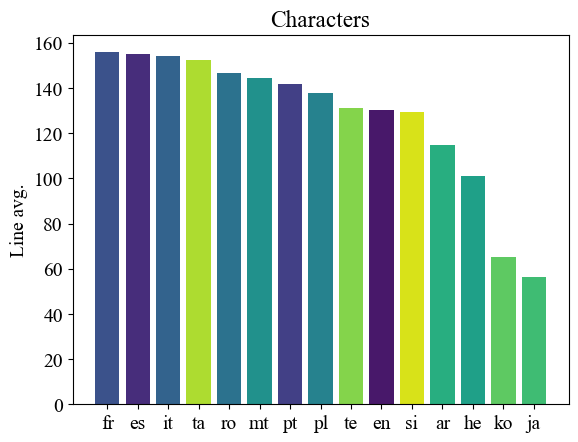

In [17]:
plot_token_numbers(flores_chars, "Characters")

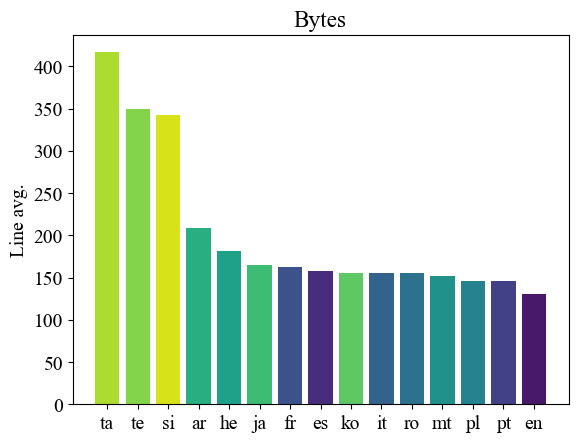

In [18]:
plot_token_numbers(flores_bytes, "Bytes")

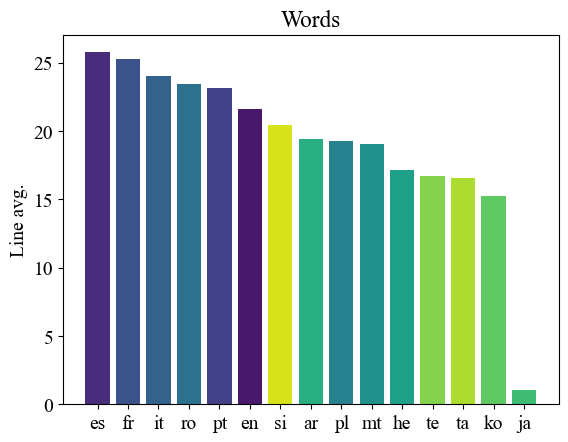

In [19]:
plot_token_numbers(flores_words, "Words")

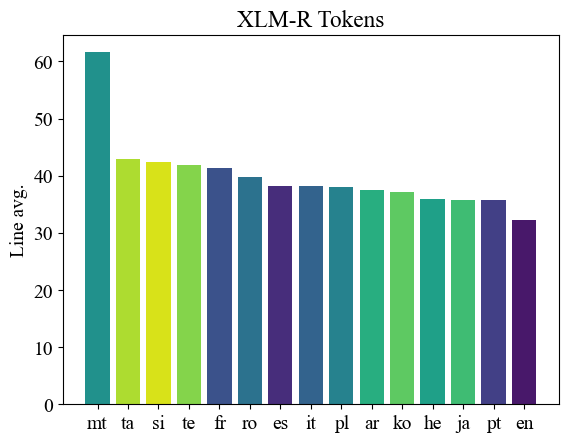

In [20]:
plot_token_numbers(flores_xlmr, "XLM-R Tokens")

## Balenced BBPE on FLORES

In [21]:
split="dev"
flores_tokenizers = build_gpt_tokenizer(f"flores200_dataset/{split}/joint.{split}", [10000, 50000,100000])
flores_il_tokenizers = {}
for lang in languages:
    flores_il_tokenizers[lang] = build_gpt_tokenizer(f"flores200_dataset/{split}/{languages_flores[lang]}.{split}", [2000, 10000,20000])


In [22]:
flores_baltok = {lang: [flores_tokenizers['tokenizer_50000'].encode(line) for line in flores[lang]] for lang in flores.keys()}
flores_il_baltok = {lang: [flores_il_tokenizers[lang]['tokenizer_10000'].encode(line) for line in flores[lang]] for lang in flores.keys()}

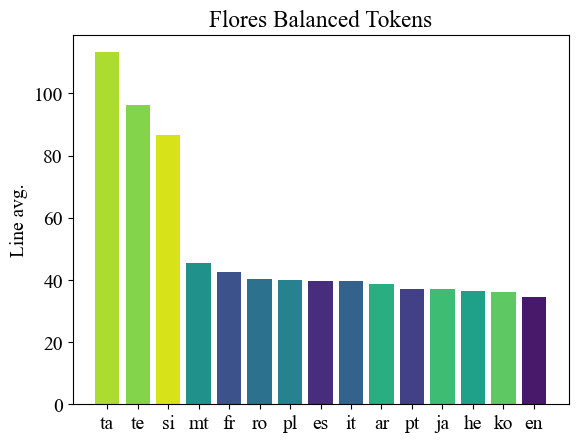

In [23]:
plot_token_numbers(flores_baltok, "Flores Balanced Tokens")

## Morfessor rewriting

In [24]:
from src.rewrite_bytes import ByteRewriter
from src.utils import str_to_hex

In [26]:
decompose_file = "byte_maps/decompose.json"
morf_map_file = "byte_maps/morf_map_decomposed_filtered_cost_clustered.json"
morf_all_map_file = "byte_maps/morf_map_all_cost_clustered.json"
decompose_rewriter = ByteRewriter(decompose_file)
morf_rewriter = ByteRewriter(morf_map_file)
morf_all_rewriter = ByteRewriter(morf_all_map_file)

flores_decomposed_rw = {lang: [decompose_rewriter.rewrite_bytes(str_to_hex(line).split(' ')) for line in flores[lang]] for lang in flores.keys()}
flores_morfs_rw = {lang: [morf_rewriter.rewrite_bytes(decompose_rewriter.rewrite_bytes(str_to_hex(line).split(' '))) for line in flores[lang]] for lang in flores.keys()}
flores_morfs_all_rw = {lang: [morf_all_rewriter.rewrite_bytes(decompose_rewriter.rewrite_bytes(str_to_hex(line).split(' '))) for line in flores[lang]] for lang in flores.keys()}

FileNotFoundError: [Errno 2] No such file or directory: 'byte_maps/morf_map_decomposed_filtered_cost_clustered.json'

In [ ]:
title = f"Morfs rewritten in UTF-8 decompose"
plot_token_numbers(flores_decomposed_rw , title)

In [ ]:
title = f"Morphs rewritten in UTF-8"
plot_token_numbers(flores_morfs_rw , title)

In [ ]:
title = f"Morfs (all) rewritten in UTF-8"
plot_token_numbers(flores_morfs_all_rw , title)

## Compare Parity

In [ ]:

plot_compare_token_numbers([flores_bytes, flores_morfs_rw, flores_morfs_all_rw, flores_chars],
                           ['bytes','m. bytes','m. bytes (all)','chars'])

In [ ]:
plot_compare_token_numbers([flores_bytes, flores_morfs_rw, flores_morfs_all_rw, flores_chars],
                           ['bytes','m. bytes','m. bytes (all)','chars'], parity='en')

In [ ]:
compression_factors = []
for lang in languages:
    byte_base = sum([len(sen) for sen in flores_bytes[lang]])
    morph_base = sum([len(sen) for sen in flores_morfs_all_rw[lang]])
    compression_factors.append(1- (morph_base/byte_base))

In [ ]:
sum(compression_factors) / len(compression_factors)

In [ ]:
sorted_languages, compression_factors = zip(*sorted(zip(languages, compression_factors), key=lambda item: item[1], reverse=True))

In [ ]:
max(compression_factors)

In [ ]:
# plot bar plot going down from 0 to 100 %

# barplot with pall

def percent_minus_formatter(x, pos):
    return f"-{x:.0f}%"

cmap = plt.cm.get_cmap('YlGn')
norm = BoundaryNorm([-0.1, 0.01, 0.05, 0.1, 0.2,  0.6, 0.7, 0.8], cmap.N)


plt.bar(sorted_languages, np.array(compression_factors) * 100, color=cmap(norm(compression_factors)))


ax = plt.gca()
formatter = FuncFormatter(percent_minus_formatter)
ax.yaxis.set_major_formatter(formatter)
ax.tick_params('x', top=True, bottom=False, labeltop=True, labelbottom=False)
ax.set_ylim([0.,70.])
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# add percent to y ticks


ax.invert_yaxis()




plt.show()

In [ ]:
compression_factors 

In [ ]:
# barplot with palette green


In [ ]:
cmap.N